# hw_8.1: Semantic Segmentation

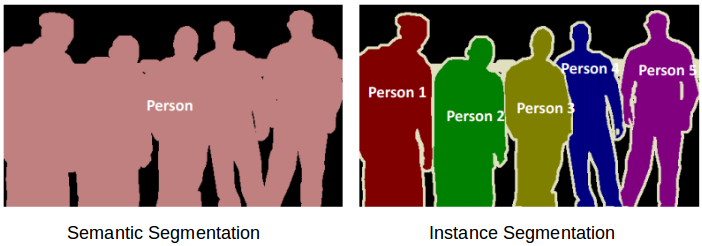

## Download data

In [1]:
!nvidia-smi
# watch -n 0.1 nvidia-smi # позволяет отслеживать статус GPU через терминал в реальном времени
!lscpu  # посмотреть сколько тредов доступно, какой CPU назначен

Tue Dec  7 00:02:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    41W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !wget https://storage.googleapis.com/keyblades/comma10k.zip

In [3]:
# !unzip -qq comma10k.zip -d /

## Imports

In [4]:
# !pip -q install ipyplot
# !pip -q install segmentation_models_pytorch

In [5]:
import torch 
import torch.nn as nn
from torchvision import transforms
import segmentation_models_pytorch as smp

from torch.utils.data import DataLoader
import cv2
from glob import glob
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from random import randint
from IPython.display import clear_output

## Settings 

In [6]:
imgs_path = '/content/comma10k/imgs'
masks_path = '/content/comma10k/masks'
imgs_path_val = '/content/comma10k/imgs_val'
masks_path_val = '/content/comma10k/masks_val'

image_size = 256

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 16
epochs = 10
num_workers = 2

In [7]:
len(os.listdir(imgs_path))

8947

In [8]:
len(os.listdir(masks_path))

8947

## Dataset 

Обучающий датасет.


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        



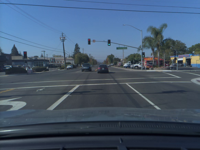
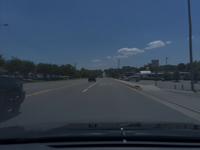
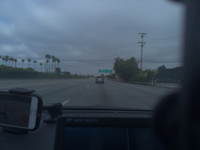
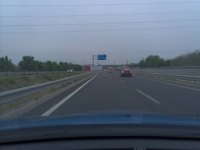
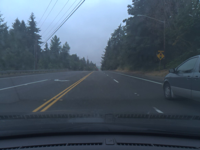
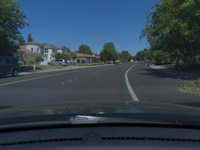
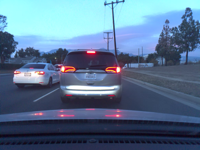
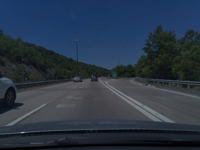
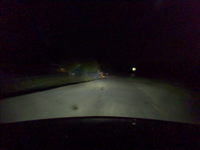
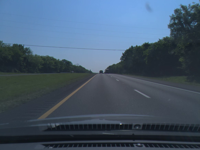
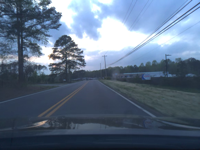
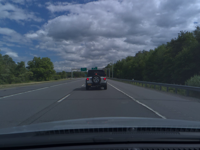
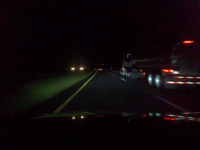
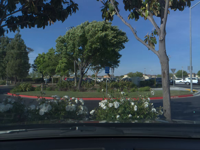


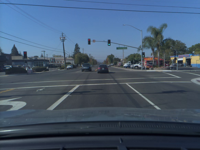
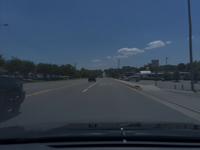
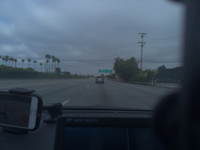
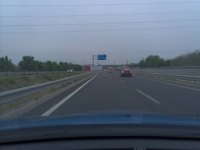
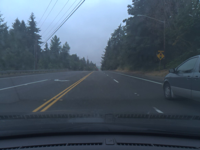
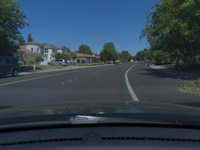
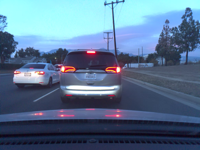
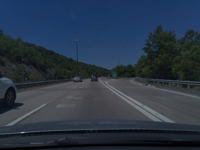
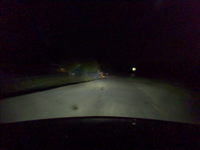
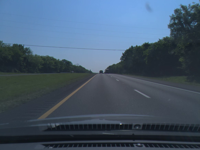
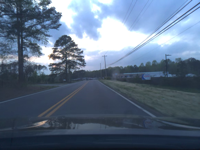
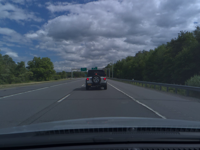
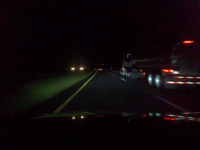
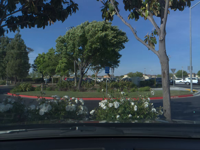

In [9]:
from ipyplot import plot_images
plot_images(glob(imgs_path+'/*'), max_images=14, img_width=200, force_b64=True)

Маски.

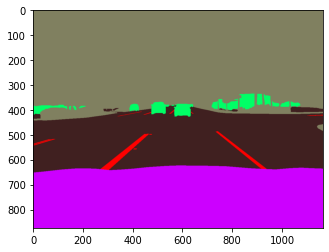

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mask = np.array(Image.open(glob(masks_path+'/*')[0]))
plt.imshow(mask)

In [11]:
class SegmentationDataset:
  def __init__(self, imgs_path, masks_path, transform=None):
    self.imgs_path = sorted(glob(f"{imgs_path}/*.png"))#[:32]
    self.masks_path = sorted(glob(f"{masks_path}/*.png"))#[:32]
    self.transform = transform

  def __len__(self):
    assert len(self.imgs_path) == len(self.masks_path)
    return len(self.imgs_path)

  def __getitem__(self, idx):
    img = cv2.imread(self.imgs_path[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # read in grayscale add 0
    mask = cv2.imread(self.masks_path[idx], 0)
    if self.transform:
      norm_img = transforms.Normalize((0.485,0.456,0.406),
                                  (0.229, 0.224, 0.225))
      img = norm_img(self.transform(img))
      # add channel to beginning
      mask = self.transform(mask).squeeze(0)
      # for this dataset
      # each pixel represents a class
      mask[mask < 0.255] = 4.0
      mask[mask < 0.35] = 3.0
      mask[mask < 0.443] = 2.0
      mask[mask < 0.54] = 1.0
      mask[mask < 0.7] = 0.0
    return img, mask

Трансформации.

In [12]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((image_size, image_size))
                              ])

Загрузчик.

In [13]:
# Train
train_dataset = SegmentationDataset(imgs_path, masks_path, transform)
train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)

# Validation
val_dataset = SegmentationDataset(imgs_path_val, masks_path_val, transform)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False) # fixed: здесь был shuffle=True

In [14]:
# test train_loader
#for data in train_loader:
#  print(data)
#  break

In [15]:
# test val_loader
#for data in val_loader:
#  print(data)
# break

## Model

In [16]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(in_channels=3, classes=5)

  def forward(self,x):
    return self.model(x)

In [17]:
def denorm(tensor):
    mean = (0.485,0.456,0.406)
    std = (0.229,0.224,0.225)
    tensor = tensor.clone()

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)
    return tensor

## Train UNet

In [18]:
model = smp.Unet(
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

opt = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

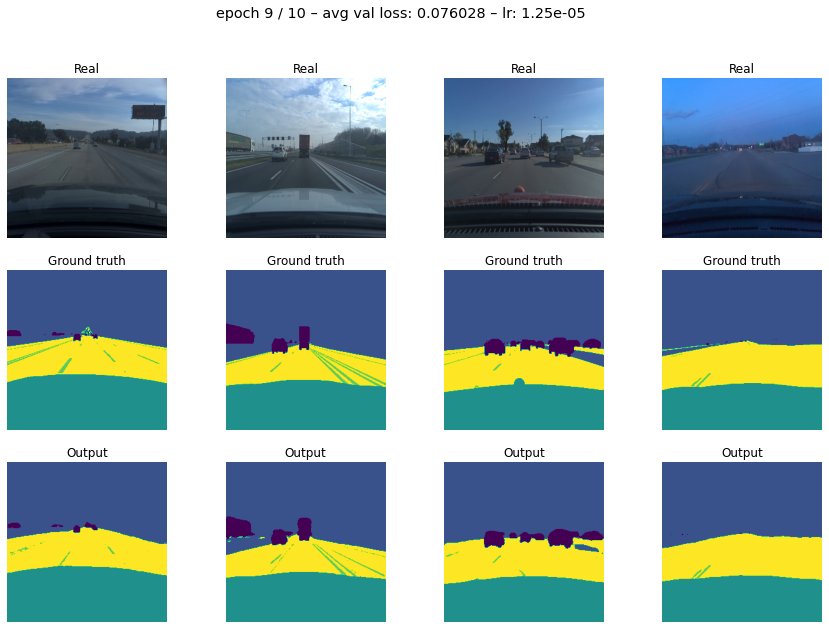

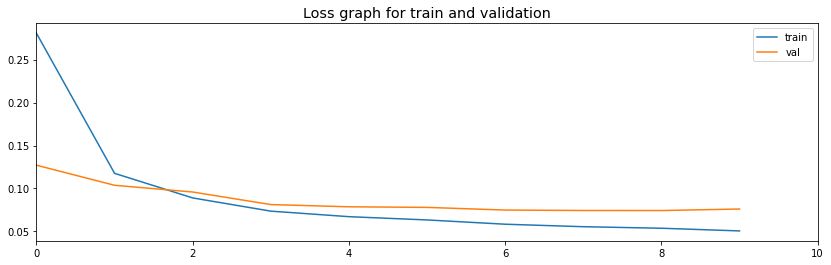

In [20]:
losses = {'train_unet': [], 'val_unet': []}

for epoch in range(epochs):
    avg_loss_train = 0
    best_val_loss = np.inf

    train_loop = tqdm(train_loader, 'Steps', total=len(train_loader))
    for X, y in train_loop:
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        avg_loss_train += loss.item() / len(train_loader)
        train_loop.set_postfix(train_loss=loss.item())

    scheduler.step()
    print(f'Train loss: {avg_loss_train:9.4f}')
    # Save train loss on this epoch
    losses['train'].append(avg_loss_train)

    with torch.no_grad():
        avg_loss_val = 0
        model.eval()
        val_loop = tqdm(enumerate(val_loader), 'Steps', total=len(val_loader))
        for i, (X, y) in val_loop:
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            avg_loss_val += loss.item() / len(val_loader)
            val_loop.set_postfix(val_loss=loss.item())

        # Save validation loss on this epoch
        losses['val'].append(avg_loss_val)

        # Detach and put into cpu
        X_cpu = X.detach().cpu()
        y_cpu = y.detach().cpu()
        y_pred_cpu = y_pred.detach().cpu()

        # Visualize, compare ground truth vs output
        clear_output(wait=True)
        plt.subplots(figsize=(15, 10))
        for k in range(4):
            plt.subplot(3, 4, k+1)
            plt.imshow(np.rollaxis(denorm(X_cpu[-k-1]).numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 4, k+5)
            plt.imshow(y_cpu[-k-1])
            plt.title('Ground truth')
            plt.axis('off')

            plt.subplot(3, 4, k+9)
            plt.imshow(y_pred_cpu[-k-1].argmax(0))
            plt.title('Output')
            plt.axis('off')
        
        lr = scheduler.get_last_lr()[0]
        text = 'epoch %d / %d – avg val loss: %f – lr: %s' % (epoch+1, epochs, avg_loss_val, lr)
        plt.suptitle(text, fontsize='x-large')
        plt.show()

        # Plotting a loss graph for train and validation
        plt.figure(figsize=(14, 4))
        plt.plot(losses['train'], label="train")
        plt.plot(losses['val'], label="val")
        plt.title('Loss graph for train and validation', fontsize='x-large')
        plt.xlim(0, epochs)
        plt.legend()
        plt.show()

        # Save the model if validation loss is better
        if avg_loss_val < best_val_loss:
            best_val_loss = avg_loss_val
            torch.save(model.state_dict(), 'unet_state_dict.pth')
            print('Sheckpoints are saved')

**Вывод:** сеть достаточно быстро выходит на плато и достигает минимума ошибки на 9 эпохе. Стратегия скедулера себя оправдала (на каждом 3-ем шаге lr уменьшается вдвое), позволив достичь еще более низкой ошибки. Финальный результат даже немного лучше, чем с DeepLabV3.

## Train DeepLabV3

In [21]:
model2 = smp.DeepLabV3(
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model2.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

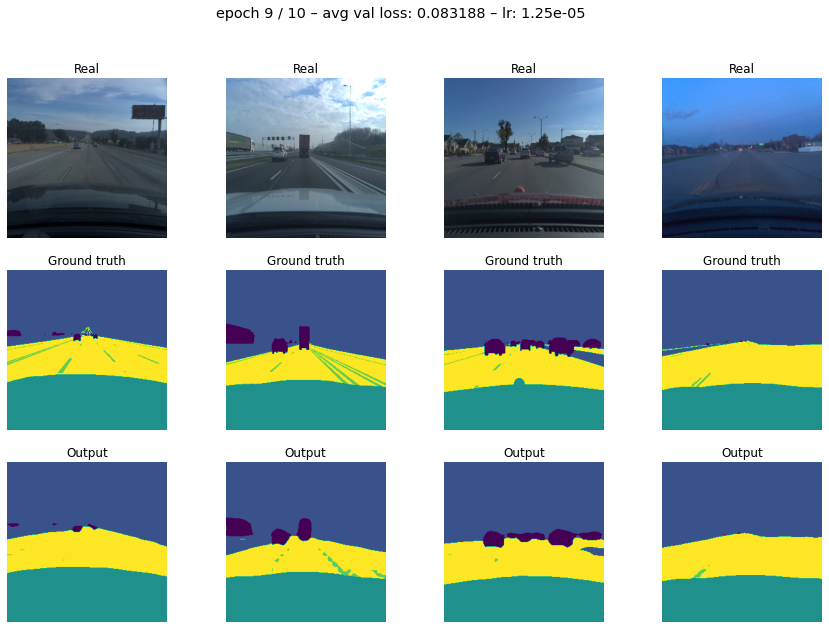

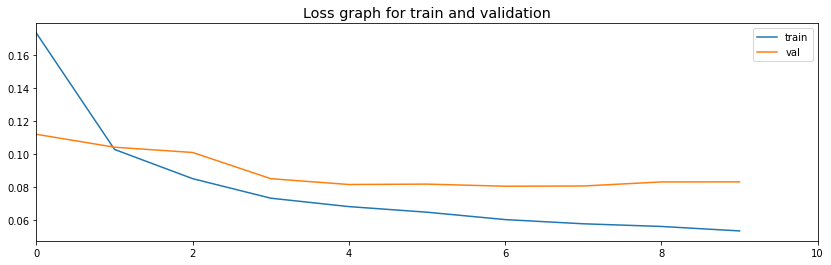

In [22]:
losses2 = {'train_dlv3': [], 'val_dlv3': []}

for epoch in range(epochs):
    avg_loss_train = 0
    best_val_loss = np.inf

    train_loop = tqdm(train_loader, 'Steps', total=len(train_loader))
    for X, y in train_loop:
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_pred = model2(X)
        loss = loss_fn(y_pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        avg_loss_train += loss.item() / len(train_loader)
        train_loop.set_postfix(train_loss=loss.item())

    scheduler.step()
    print(f'Train loss: {avg_loss_train:9.4f}')
    # Save train loss on this epoch
    losses2['train'].append(avg_loss_train)

    with torch.no_grad():
        avg_loss_val = 0
        model2.eval()
        val_loop = tqdm(enumerate(val_loader), 'Steps', total=len(val_loader))
        for i, (X, y) in val_loop:
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_pred = model2(X)
            loss = loss_fn(y_pred, y)

            avg_loss_val += loss.item() / len(val_loader)
            val_loop.set_postfix(val_loss=loss.item())

        # Save validation loss on this epoch
        losses2['val'].append(avg_loss_val)

        # Detach and put into cpu
        X_cpu = X.detach().cpu()
        y_cpu = y.detach().cpu()
        y_pred_cpu = y_pred.detach().cpu()

        # Visualize, compare ground truth vs output
        clear_output(wait=True)
        plt.subplots(figsize=(15, 10))
        for k in range(4):
            plt.subplot(3, 4, k+1)
            plt.imshow(np.rollaxis(denorm(X_cpu[-k-1]).numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 4, k+5)
            plt.imshow(y_cpu[-k-1])
            plt.title('Ground truth')
            plt.axis('off')

            plt.subplot(3, 4, k+9)
            plt.imshow(y_pred_cpu[-k-1].argmax(0))
            plt.title('Output')
            plt.axis('off')
        
        lr = scheduler.get_last_lr()[0]
        text = 'epoch %d / %d – avg val loss: %f – lr: %s' % (epoch+1, epochs, avg_loss_val, lr)
        plt.suptitle(text, fontsize='x-large')
        plt.show()

        # Plotting a loss graph for train and validation
        plt.figure(figsize=(14, 4))
        plt.plot(losses2['train'], label="train")
        plt.plot(losses2['val'], label="val")
        plt.title('Loss graph for train and validation', fontsize='x-large')
        plt.xlim(0, epochs)
        plt.legend()
        plt.show()

        # Save the model2 if validation loss is better
        if avg_loss_val < best_val_loss:
            best_val_loss = avg_loss_val
            torch.save(model2.state_dict(), 'deeplabv3_state_dict.pth')
            print('Sheckpoints are saved')

**Вывод:** сеть достигает минимальной ошибки на 7 эпохе. Результат примерно такой же, как с UNet, однако сильнее переобучение на последних эпохах, значит нужно менять стратегию скедулера на более агрессивную.